In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
tau_vals = [0.1, 0.3, 0.5, 0.9, 0.99]


# Multi-quantile estimations

In [2]:
# Dataset generation
distros = ['mix', 'gau_1', 'gau_2', 'exp']

def get_one_dt(distro, datasize):
#     return np.ones(size)
    if distro == 'gau_1':
        return np.random.normal(2, 18, datasize)
    elif distro == 'gau_2':
        return np.random.normal(0, 0.001, datasize)
    elif distro == 'mix':
        # mean: -1.3
        # std: 30.779035604224564
        # var: 947.3490327261234
        mix_lst = np.zeros(datasize)
        sizes = np.array([0.3, 0.2, 0.1, 0.15, 0.25])
        mixtures = [(2,7), (0,0.7), (36, 26), (5,77), (-77,7)]
        acc_sizes = [sum(sizes[:i+1]) for i in range(len(sizes))]

        for d_idx in range(datasize):
            rdn = np.random.uniform(0,1)
            mix_id = 0
            for m_id in acc_sizes:
                if rdn > m_id:
                    mix_id += 1
                else:break
            data_point = np.random.normal(mixtures[mix_id][0], mixtures[mix_id][1])
            mix_lst[d_idx] = data_point
        return mix_lst
    elif distro == 'exp':
        return np.random.exponential(scale=1, size=datasize)*6.5 - 20
    else: raise Exception("distribution doesn't work!")

In [3]:
# dt = get_one_dt('exp', 10000)
# plt.hist(dt, bins=100)

## Joint Tracking of Multiple Quantiles Through Condition Quantiles

1. Algo based on DUMIQUE (basically SGD but claim itself not ablt to deal with non-positive quantiles directly)

In [4]:
# not sure why *q_est --> Cannot deal with q_est<0
def DUMIQUE(q_est, x, tau, stepsize):
    if q_est < 0: raise Exception("!!!", q_est)
    if x > q_est:
        q_est += (stepsize*q_est)*tau
    else:
        q_est += (stepsize*q_est)*(tau-1)
    return q_est

# SGD which works for q_est non positive, only constant stepsize
def sgd(q_est, x, tau, stepsize):
    if x > q_est:
        q_est += stepsize*tau
    else:
        q_est += stepsize*(tau-1)
    return q_est

In [5]:
def checkinput(q_est):
    q_new = [-0.001]
    q_new.extend([q_est[i] for i in range(len(q_est)-1)])
    for i in range(len(q_est)):
        if q_new[i] >= q_est[i]: return False
    return True

# sX is stepsize_X, sY is stepsize_Y
# c = 2 because 0.5 is at tau_vals[2]
def shiftQ(dataset, tau_lst, sX, sY, qX, qY, c=0):
    if not (checkinput(qX) and checkinput(qY)):
        raise Exception("Input quantile estimate not applicable")
    count = 0
    proc = np.zeros((len(dataset), len(tau_lst)))
    for i, x in enumerate(dataset):
        qX[c] = DUMIQUE(qX[c], x, tau_lst[c], sX)

        for k in range(c-1, -1, -1):
            tau = tau_lst[k]
#           shifted observation
            yk = qX[k+1] - x
#           shifted Y distro
            qY[k] = DUMIQUE(qY[k], yk, 1-tau, sY)
#           shift back
            qX[k] = qX[k+1] - qY[k]
#             print ('yk', yk)
#             print ('qY', qY)
#             print ('qX', qX)
        
        for k in range(c+1, len(qX)):
            tau = tau_lst[k]
            yk = -qX[k-1] + x
            qY[k] = DUMIQUE(qY[k], yk, tau, sY)
            qX[k] = qX[k-1] + qY[k]
#             print ('yk',yk)
#             print ('qY', qY)
#             print ('qX', qX)
#         print ('qY', qY)
        if not (checkinput(qX)):
            count += 1
        proc[i] = qX
    print ("shiftQ Overall crossing", count)
    return proc


shiftQ Overall crossing 0


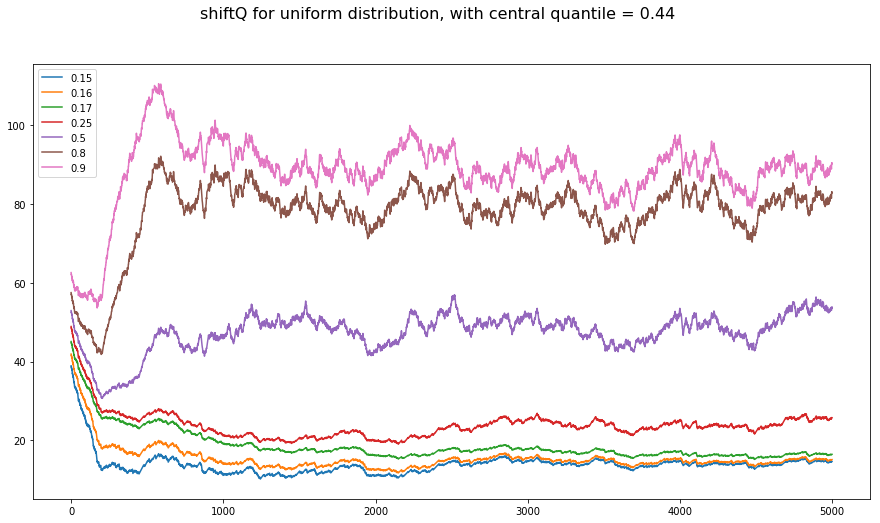

[[14.52265116 15.00465457 16.35632022 25.57952964 53.69880236 83.10650993
  90.49996429]
 [14.55622824 15.03678565 16.38412596 25.65345144 53.49153142 82.78160816
  90.16027562]
 [14.58983442 15.06895015 16.41197898 25.72765108 53.84411187 83.0170283
  90.38093842]]


In [6]:
dataset = np.random.uniform(0, 100, 5000)
qX = np.asarray([10.0, 23, 45, 66, 70.0, 80, 90])
qY = np.asarray([30.0, 32, 36, 38, 40.0, 45, 50])/10.0
tau_lst = [0.15, 0.16, 0.17, 0.25, 0.5, 0.8, 0.9]
proc = shiftQ(dataset, tau_lst, 0.01, 0.02, qX, qY, 2)
# print (proc)
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
ax.plot(proc)
ax.legend(tau_lst)
fig.suptitle("shiftQ for uniform distribution, with central quantile = 0.44", fontsize = 16)
plt.show()

print (proc[-3:, :])


#### Explanation

1. **Overall:** The basic idea is to estimate a central quantile point, and update other quantiles based on the central one. 

2. **Motivation:** The difference $diff$ between the two quantiles for the $x_{n}$ observation is:
$$
diff = |Q_x(q_{k+1}) - Q_x(q_k)|
$$
    Note that $diff > 0$ for all time, so different quantiles never cross each other. This property is guaranteed by the update function DUMIQE() and its restriction that the input quantile estimate must > 0.

2. **Update one quantile:** The difference is calculated based on the idea of "shift distribution". Let $X$ denotes the original distribution of data stream, and let distribution $Y$ denotes a shifted version of $X$ such that $Y = X + constant$. In this way, the quantile $q_{k+1}$ can be updated by implementation of shifting. The basic steps are:
    1. Calculate $Q_x(q_k)$, which is the shift constant
    2. Get shift observation $y_{k+1} =  Q_x(q_k) - x$
    3. Calculate the new quantile $Q_y(q_{k+1})$ in $Y$
    4. Shift the change back to $X$: $Q_x(q_{k+1}) = Q_y(q_{k+1}) + shiftConstant$

3. **Update the bigger quantiles:** Starting from central quantile $q_c$, the estimates for $q_{c+1}, ..., q_{K}$ are calculated one based on another. So each time step 2 is repeated from $q_c$ to $q_{K-1}$

4. **Update the smaller quantiles:** Similar to step 3, for smaller quantiles, estimates for $q_{c-1}, ..., q_{1}$ are calculated similarly one based on another.

#### Observation and Analysis

1. The quantiles greater than the central quantile work well. We can see the biggest 3 quantiles are converging close to the true quantiles.

2. The quantiles smaller than central quantile converges to the central quantile. Specially, the smallest quantile first converge to the second one, then the second one to the third one, until all of the small ones converge to the central one.
    
    **Explanation:**
    
    Let's assume $Q_x(q_{c-1})$ is already on it's track converging to $Q_x(q_c)$.
    On the arrival of new observation $x$, the update of $Q_x(q_{c-1})$ is 
    $$ Q_x(q_{c-1}) = Q_x(q_{c}) - Q_y(q_{c-1})$$
    We can observe from the data the difference $Q_y(q_{c-1})$ is decreasing. But I don't know why
    
    
    
    

### Comparison with SGD

In [7]:
def SGD(dataset, tau_lst, stepsize, q):
    count = 0
    if not (checkinput(q)):
        raise Exception("Input quantile estimate not applicable")
    proc = np.zeros((len(dataset), len(tau_lst)))
    for i, x in enumerate(dataset):
        for k in range(len(tau_lst)):
            tau = tau_lst[k]
            q[k] = sgd(q[k], x, tau, stepsize)
        if not (checkinput(q)):
            count += 1
#             print ("!!! Cross !!!", q)
        proc[i] = q
    print ("SGD overall crossings", count)
    return proc

SGD overall crossings 225


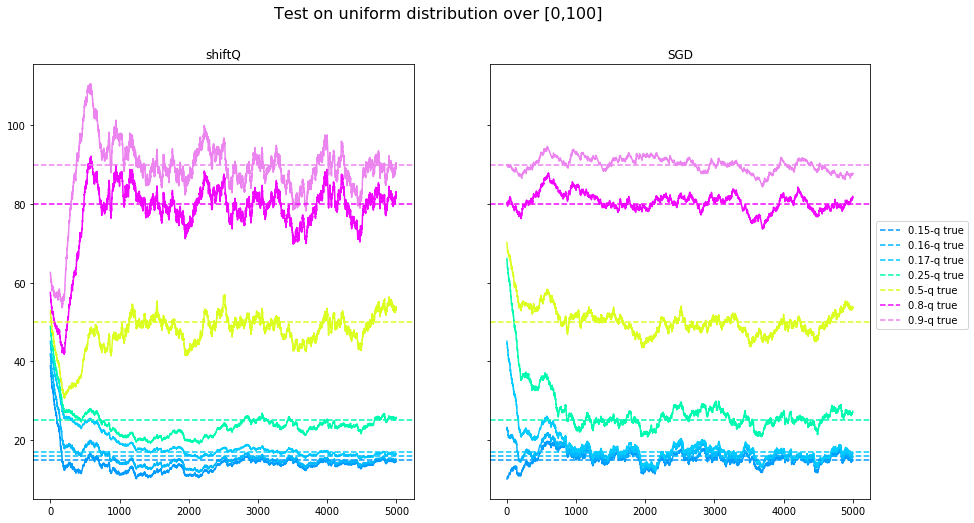

ShiftQ res [14.58983442 15.06895015 16.41197898 25.72765108 53.84411187 83.0170283
 90.38093842]
SGD res    [14.95 15.8  16.65 27.3  53.8  81.8  87.75]
True res   [15. 16. 17. 25. 50. 80. 90.]


In [8]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

c_Norm = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=c_Norm, cmap=plt.get_cmap('gist_ncar'))

qX = np.asarray([10.0, 23, 45, 66, 70.0, 80, 90])
# print (qX)
proc2 = SGD(dataset, tau_lst, 0.45, qX)
q_true = np.asarray(tau_lst)*100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 8), sharey=True)

for idx, qt in enumerate(q_true):
    colorVal = scalarMap.to_rgba(tau_lst[idx])                
    ax.axhline(qt, linestyle='--', color=colorVal, label=(str(tau_lst[idx])+'-q true'))
            
for i, p in enumerate(proc.T): 
    colorVal = scalarMap.to_rgba(tau_lst[i])
    ax1.plot(p, color=colorVal)
ax1.set_title("shiftQ")


for i, p in enumerate(proc2.T):
    colorVal = scalarMap.to_rgba(tau_lst[i])                
    ax2.plot(p, color=colorVal)
# ax2.plot(proc2)
ax2.set_title("SGD")



# print (q_true)

for i, qt in enumerate(q_true):
    colorVal = scalarMap.to_rgba(tau_lst[i])               
    ax1.axhline(qt, linestyle='--', color = colorVal, label=(str(tau_lst[i])+'-q true'))
    ax2.axhline(qt, linestyle='--', color = colorVal, label=(str(tau_lst[i])+'-q true'))

# lgd =  ([(str(t)+'-quantile') for t in tau_lst])
# ax1.legend(lgd)
lgd = ax1.legend(bbox_to_anchor=(2.47, 0.65), ncol = 1)

fig.suptitle("Test on uniform distribution over [0,100]", fontsize=16)
plt.show()
fig.savefig("shiftQ_vs_SGD.png", bbox_extra_artists=[lgd, fig], bbox_inches='tight')

print ("ShiftQ res", proc[-1, :])
print ("SGD res   ", proc2[-1, :])
print ("True res  ", q_true)

Obviously SGD is better: it at least conveges to the correct value. But **crossing problem not solved**

## Joint Tracking of Multiple Quantiles Through Condition Quantiles

Algo based on QEWA -- Too complicated, not going to implement this now


### Tracking Quantiles of Network Data Streams with Dynamic Options

Jin Cao, ...

Not going to implement this

## P2

Exponentially Weighted Simultaneous Esimation of Several Quantiles

In [41]:
def find_k(x, q_lst):
    rtn = len(q_lst)-2
    for i, q in enumerate(q_lst):
        if x < q: 
            rtn = i-1
            break
    return max(0,rtn)
        
# find_k(18.8, np.arange(3, 20))

15

In [25]:
def adjust_ends(lst, x):
    lst[0] = min(lst[0], x)
    lst[-1] = max(lst[-1],x)
    return lst

# adjust_ends([-1,2,3,100], 200)

[-1, 2, 3, 200]

In [38]:
def update_marker_lst(marker_lst, k):
    for i in range(k+1, len(marker_lst)):
        marker_lst[i] += 1
    return marker_lst
# update_marker_lst([3,45,6,7,8], 3)

[3, 45, 6, 7, 9]

In [61]:
def p2(d, q, q_m, q_p, n, n_m, n_p):
    q_new = q + d/(n_p - n_m) \
        * ((n - n_m + d) * (q_p - q)/(n_p - n)\
         + (n_p - n - d) * (q - q_m)/(n - n_m))
    return q_new

In [109]:
# main function

def ext_p2(dataset, tau_lst):
    m = 2*len(tau_lst) + 3
    
    # 0 = p1 < p2 < ... < pm = 1
    # m elements overall
    ext_tau_lst = extend_tau_lst(tau_lst)
    if (len(ext_tau_lst)!= m): raise Exception("len(ext_tau_lst)"+str(len(ext_tau_lst))+" m is "+str(m))
        
    # q1 < q2 < ... < q(m)
    # m elements overall
    ext_q_lst = np.sort(dataset[:m])
    min_x, max_x = ext_q_lst[0], ext_q_lst[-1]
    if (len(ext_q_lst)!= m): raise Exception("len(ext_q_lst)"+str(len(ext_q_lst))+" m is "+str(m))

    # current marker positions
    # n1 < n2 < ... < nm
    marker_lst = np.arange(1, m+1)
    
    # desired marker positions
    # n'1 < n'2 < ... < n'm
    # n'i = (N-1)*tau + 1, where N is the number of current observations so far
    desired_marker_lst = (m-1)*ext_tau_lst + 1
    ext_q_reco = np.zeros((len(dataset)-(m), m))
    
#     print (marker_lst, desired_marker_lst)
    
    for i, x in enumerate(dataset[m:]):
#         print ("data point number", i, ":", x)
        
        k = find_k(x, ext_q_lst)
        ext_q_lst = adjust_ends(ext_q_lst, x)
        # -------------- !!! 
        # notice the P2 paper got it wrong: 
        # in the algorithm "Box 1" PartB.2. Increment positions of markers k+1 through 5:
        # n_i += 1,   i = k,  ..., 5
        # should be   i = k+1,..., 5
        # otherwise the position of n_0 might change, which should never happen
        marker_lst = update_marker_lst(marker_lst, k)
        if marker_lst[-1] != i+1 + m or marker_lst[0] != 1: raise Exception("marker_lst wrong")
        desired_marker_lst = np.around(desired_marker_lst + ext_tau_lst, 4)

        #adjust heights of the inbetween markers n_1 ~ n_(m-2) if necessary
        for idx in range(1, m-1):
            n_p, n, n_m = marker_lst[idx+1], marker_lst[idx], marker_lst[idx-1]
            n_desire = desired_marker_lst[idx]
            d = round(n_desire - n, 2)
            
            if (d>=1 and n_p-n > 1) or (d<=-1 and n_m-n <-1):
                d = -1 if d<0 else 1
                q_m, q, q_p = ext_q_lst[idx-1], ext_q_lst[idx], ext_q_lst[idx+1] 
                
                # p2 adjustment
                q_new = p2(d, q, q_m, q_p, n, n_m, n_p)
                if q_m < q_new < q_p:
                    q = q_new
                    
                # linear adjustment
                else:
                    q2 = q_p if d>0 else q_m
                    n2 = n_p if d>0 else n_m
                    q = q + d * (q2-q)/(n2-n)
                
                ext_q_lst[idx] = q
                marker_lst[idx] = n+d
                
        ext_q_reco[i] = ext_q_lst
    return ext_q_reco

In [69]:
def get_original_lst(ext_lst):
    m = len(ext_lst)-2
    k = int((m-1)/2)
    lst = np.zeros(k)
    for i in range (1, m):
        if i % 2 == 0: 
            lst[int(i/2)-1] = ext_lst[i]
            
    return lst

In [107]:
def test(tau_lst):
    print (extend_tau_lst(tau_lst))
    dt = np.random.normal(-20, 0.001, 1000)
    L = len((extend_tau_lst(tau_lst)))
    q_true=np.percentile(dt, np.array(tau_lst) * 100)
    q_lst= ext_p2(dt, tau_lst)
    return q_true, q_lst.T

tau_lst = [0.001, 0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 0.999]
true_q, q_res = test(tau_lst)
print (true_q)

[0.000e+00 5.000e-04 1.000e-03 5.500e-03 1.000e-02 3.000e-02 5.000e-02
 7.500e-02 1.000e-01 1.750e-01 2.500e-01 3.750e-01 5.000e-01 6.250e-01
 7.500e-01 8.250e-01 9.000e-01 9.250e-01 9.500e-01 9.700e-01 9.900e-01
 9.945e-01 9.990e-01 9.995e-01 1.000e+00]
[-20.00261977 -20.00214632 -20.00159523 -20.00126538 -20.00065523
 -19.99999908 -19.99931954 -19.99873559 -19.99841782 -19.99774396
 -19.99670668]


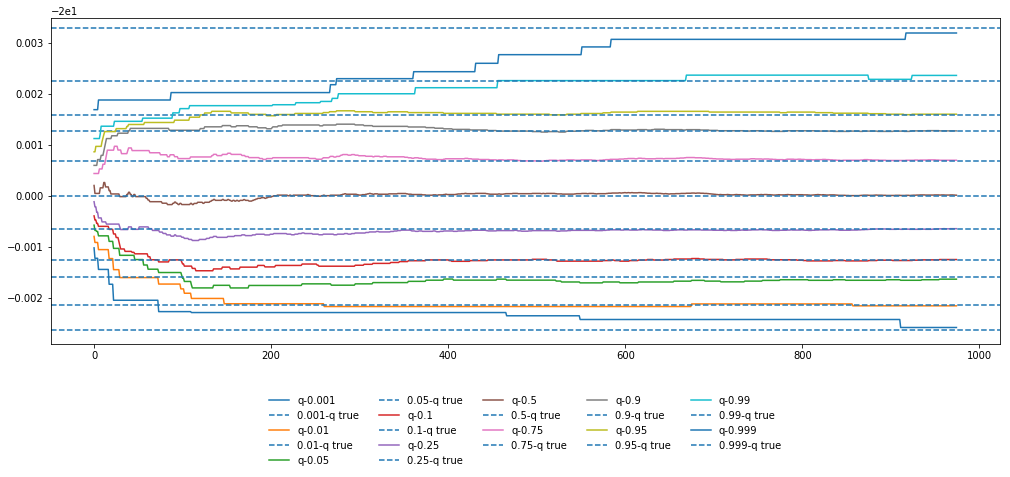

In [108]:
ext_tau_lst = np.round(extend_tau_lst(tau_lst), 4)

fig, (ax2) = plt.subplots(1, 1, figsize = (17, 6))
for i in range(len(tau_lst)):
    ax2.plot(q_res[(i+1)*2], label = 'q-{}'.format(tau_lst[i]))
    ax2.axhline(true_q[i], linestyle='--',label=(str(tau_lst[i])+'-q true'))
lgd = ax2.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4),
            frameon=False, ncol=5)
plt.show()